In [1]:
# Zdefiniowanie struktury
struct Dual{T <:Number} <: Number
    v::T
    dv::Vector{T}
end

In [2]:
using MLDatasets
using ImageCore

# Wczytanie danych do trenowania sieci
train_x = MNIST.testtensor(Float64)
train_y = MNIST.testlabels()

# Wczytanie danych do testowania sieci
test_x,  test_y  = MNIST.testdata()

MNIST.convert2image(MNIST.traintensor(1))

In [3]:
# Podstawowe operacje na liczbach dualnych
import Base: +, -, *, /
-(x::Dual)              = Dual(-x.v,         -x.dv)
+(x::Dual,   y::Dual)   = Dual( x.v + y.v,   x.dv + y.dv)
-(x::Dual,   y::Dual)   = Dual( x.v - y.v,   x.dv - y.dv)
+(x::Dual,   y::Number) = Dual( x.v + y,     x.dv)
-(x::Number, y::Dual)   = Dual( y.v - x,     y.dv)
+(x::Number, y::Dual)   = Dual( y.v + x,     y.dv)
-(x::Dual,   y::Number) = Dual( x.v - y,     x.dv)
*(x::Dual,   y::Dual)   = Dual( x.v * y.v,   x.dv.* y.v + x.v.* y.dv)
*(x::Dual,   y::Number) = Dual( x.v * y,     x.dv.* y)
/(x::Dual,   y::Dual)   = Dual( x.v / y.v,   (x.dv * y.v - x.v * y.dv)/y.v^2)
/(x::Dual,   y::Number) = Dual( x.v / y,     x.dv/y)
*(x::Number, y::Dual)   = Dual( y.v * x,     y.dv * x)
/(x::Number, y::Dual)   = Dual( y.v / x,     y.dv/x)


import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),  sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v),  cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),  -sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v),  one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v),  exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v), .5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;


# Pomocne funkcje
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;


import Base: convert, promote_rule

convert(::Type{Dual{T}}, x::Dual) where T =
Dual(convert(T, x.v), convert(Vector{T}, x.dv))

convert(::Type{Dual{T}}, x::Number, len::Number) where T =
Dual(convert(T, x), zeros(T,len))

convert(::Type{Dual{T}}, x::Number) where T =
Dual(convert(T, x), zeros(T,chunk))

promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} =
Dual{promote_type(T,R)}

promote_rule (generic function with 148 methods)

In [4]:
function accuracy(predictions, references)
    counter = 0
    for i=1:length(predictions)
        if predictions[i] == references[i]
            counter +=1
        end 
    end
return counter/length(predictions)
end

accuracy (generic function with 1 method)

In [5]:
# Inicjalizacja - pierwszy wektor wag - pierwsze losowe, później zmieniane
Wh = randn(20, 784)
Wo = randn(1, 20)

# Inicjalizacja wektorów na wzór Wh i Wo
dWh = similar(Wh)
dWo = similar(Wo)

1×20 Matrix{Float64}:
 5.0e-324  5.60171e-315  5.0e-324  5.60171e-315  …  5.0e-324  5.60171e-315

In [6]:
# Funkcja wywołująca partials i f na liczbie dualnej, gdzie druga część tej liczby to 1
#D = derivative(f, x) = partials(f(Dual(x, one(x))))


# Funkcja sigmoidalna przyjmująca wartości <0;1>
#     1
#  __________
#  1 + e^(-x)

σ(x) = one(x) / (one(x) + exp(-x)) 

σ (generic function with 1 method)

In [9]:
#Jakobian - różniczkowanie

# J = function jacobian(f, args::Vector{T}) where {T <:Number}
#     jacobian_columns = Matrix{T}[]
    
#     for i=1:length(args)
#         x = Dual{T}[]
#         for j=1:length(args)
#             seed = (i == j)
#             push!(x, seed ?
                
#                 Dual(args[j], one(args[j])) :
#                 Dual(args[j],zero(args[j])) )
#         end
#         column = partials.([f(x)...])
#         push!(jacobian_columns, column[:,:])
#     end
#     hcat(jacobian_columns...)
# end

chunk = 10
J = function jacobian(f, chunk, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:ceil(length(args)/chunk)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (j > (i-1) * chunk && j <= i*chunk)
            if seed
                ones = zeros(Float64, chunk)
                index = mod(j -1, chunk)
                ones[index + 1] = 1
                push!(x, Dual(args[j], ones))
            else
                push!(x, Dual(args[j], zeros(Float64, chunk)))
            end
        end
        column = partials.(f(x) ...)
        push!(jacobian_columns, column[:,:])
    end
    hjacobian = hcat(jacobian_columns...)
    return hjacobian
end

jacobian (generic function with 1 method)

In [10]:
# Optymalizacja - wybrana metoda Adam

abstract type DescentMethod end
struct GradientDescent <: DescentMethod
 α # learning rate
end

mutable struct Adam <: DescentMethod
 α # learning rate
 ε # small value
 v # sum gradient
 s # sum of squared gradient
 γs # gradient decay
 γv # momentum decay
 k # step counter
 Adam() = new() # new uninitialized structure
end


function init!(M::Adam, θ; α=0.001, γv=0.9, γs=0.999, ε=1e-8)
 M.α = α
 M.ε = ε
 M.γs = γs
 M.γv = γv
 M.s = zero(θ)
 M.v = zero(θ)
 M.k = 0
 return M
end


init! (generic function with 1 method)

In [11]:
# struct Dual{T <:Number} <: Number
#     v::T
#     dv::Vector{T}
# end

y_out = Dual{Float64}[]
println(typeof(y_out))

Vector{Dual{Float64}}


In [22]:
# Uczenie 

# dense(w, n, m, v, f) = f.(reshape(w, n, m) * v)
# mean_squared_loss(y, ŷ) = sum(0.5(y - ŷ).^2)
# linear(x) = x
# σ(x) = one(x) / (one(x) + exp(-x))
# Wh = randn(10,2)
# Wo = randn(1,10)
# x, y = [1.98;4.434], [0.064]
# dWh = similar(Wh)
# dWo = similar(Wo)
# function net(x, wh, wo, y)
# x̂ = dense(wh, 10, 2, x, σ)
#  ŷ = dense(wo, 1, 10, x̂, linear)
#  E = mean_squared_loss(y, ŷ)
# end
# dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
# dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);
# epochs=10
# for i=1:epochs
#  E = net(x, Wh[:], Wo[:], y)
#  dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y)
#  dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y)
#  Wh -= 0.1dWh
#  Wo -= 0.1dWo
# end

using BenchmarkTools



dense(w, n, m, v, f) = f.(reshape(w, n, m) * v)
mean_squared_loss(y, ŷ) = sum(0.5(y - ŷ).^2)
linear(x) = x

y_out =  Dual{Float64}[]
step_Wh = similar(Wh)
step_Wo = similar(Wo)

x_conv = Array{Dual{Float64}}(undef, 784, 1) 

# E - wartość błędu; uczenie sieci -> błąd możliwie mały
E = Float64[]

function net(x, wh, wo, y, chun_len)
    d = reshape(wh, 20, 784)
    x̂ = dense(d, 20, 784, x, linear)
    ŷ = dense(wo, 1, 20, x̂ , σ)
    #push!(y_out, ŷ)
    E = mean_squared_loss.(y, ŷ)
    return E
end


dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y, chunk), chunk, wh);
dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y, chunk), chunk, wo); 

epochs = 20

    function net2(x, wh, wo, y)
        x̂ = dense(wh, 20, 784, x, σ)
        ŷ = dense(wo, 1, 20, x̂ , linear)
        E = mean_squared_loss(y, ŷ[1])
        return ŷ, E
    end



    x = train_x[:,:,1]

    m = Adam()
    M = init!(m, Wh)
    m1 = Adam()
    Mo = init!(m1, Wo)
    j = 1
    
function startNet(Wh, Wo)
    for i = j*50:(j*50+50-1)
        x = train_x[:,:,i]
        x = x[:]
        y = train_y[i, :]

        # dnet - informuje, które wagi jak bardzo zmienić, żeby błąd był większy
        # dWh, dWo - liczymy pochodną błędu E względem warstw ukrytej i wyjściowej
        dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y)
        dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y)

        # Adam dla warstwy ukrytej Wh
        γs, γv = M.γs, M.γv
        α, ε, k = M.α, M.ε, M.k
        s, v, g = M.s, M.v, dWh
        M.s = s
        v[:] = γv*v + (1.0 - γv) * g
        s[:] = γs*s + (1.0 - γs) * g .* g
        M.k = k += 1
        v̂ = v ./ (1.0 - γv^k)
        ŝ = s ./ (1.0 - γs^k)

        step_Wh = - α*v̂ ./ (sqrt.(ŝ) .+ ε)
        Wh = Wh - 0.1*step_Wh


        # Adam dla warstwy wyjściowej Wo
        γso, γvo = Mo.γs, Mo.γv
        αo, εo, ko = Mo.α, Mo.ε, Mo.k
        so, vo, go = Mo.s, Mo.v, dWo
        Mo.s = so
        vo[:] = γvo*vo + (1.0 - γvo) * go
        so[:] = γso*so + (1.0 - γso) * go .* go
        Mo.k = ko += 1
        v̂o = vo ./ (1.0 - γvo^ko)
        ŝo = so ./ (1.0 - γso^ko)

        step_Wo = - αo*v̂o ./ (sqrt.(ŝo) .+ εo)
        Wo = Wo - 0.1*step_Wo

        # Błąd
        Ei = net(x, Wh[:], Wo[:], y, chunk)
        push!(E, Ei[1])

    end
    
end   

    @btime startNet(Wh,Wo)
    y_outputs = Int64[]



    tests = 20

    for i=1:tests
        x = test_x[:,:,i]
        x = x[:]
        y = test_y[i]
        y_out, Ei = net2(x, Wh[:], Wo[:], y)
        #println("oczekiwana wartość:", y, "co wyszło:", y_predicted[1])
        push!(y_outputs, abs(round(Int64,y_out[1])))
    end
    println(accuracy(y_outputs,test_y[1:20]))

    println(y_outputs)
    println(test_y[1:20])
 




# Wypisz błędy

  383.069 s (3705594152 allocations: 545.15 GiB)
0.15
[0, 0, 0, 0, 4, 3, 2, 1, 1, 4, 1, 3, 4, 0, 2, 2, 3, 1, 1, 2]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]


In [130]:
# Testy

# rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x)
# v = -1:.1:+1
# n = length(v)
# xv = repeat(v, 1, n)
# yv = repeat(v',n, 1)
# dz = rosenbrock.(xv .+ ϵ, yv)
# dzdx = partials.(dz)
# dz = rosenbrock.(xv, yv .+ ϵ)
# dzdy = partials.(dz)
# z = value.(dz)
# using PyPlot
# contourf(xv, yv, z)
# quiver(xv, yv, dzdx, dzdy)





In [131]:
# Wykresy - dane testowe+wyniki sieci; błąd sieci

using Plots
x = 1:length(E)
y = test_y[1:20]
y_data = hcat(y, y_outputs)
println(y_data)
plot(x,y_data, yticks = 0:1:20, seriestype = :scatter, label = ["Wartość testowa" "Wartość przewidziana"], lw = 10)

[7 2; 2 1; 1 5; 0 4; 4 1; 1 5; 4 5; 9 2; 5 1; 9 3; 0 2; 6 3; 9 3; 0 3; 1 2; 5 3; 9 2; 7 0; 3 1; 4 2]


LoadError: Expects 50 elements in each col of y, found 20.

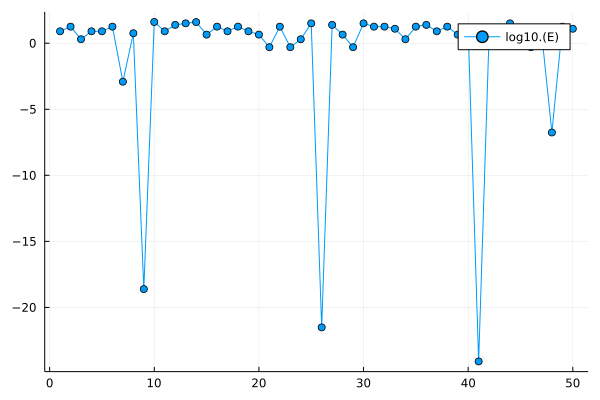

In [132]:
y=log10.(E)
y
plot( y, label="log10.(E)", marker=:circle)


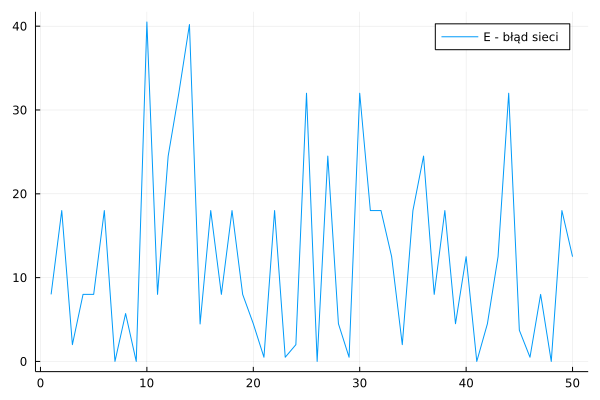

In [133]:
using Plots
x = 1:length(E)
plot(x,E,label="E - błąd sieci")